**dependencies**

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

 
from tensorflow import keras
from tensorflow.keras import layers

## necessary hyperparameters

In [2]:
# Define hyperparameters
EPOCHS = 50
BATCH_SIZE = 128
noise_dim = 100
num_examples_to_generate = 16



# dataset preprosessing

## load images dataset

11490434/11490434 [==============================] - 2s 0us/step


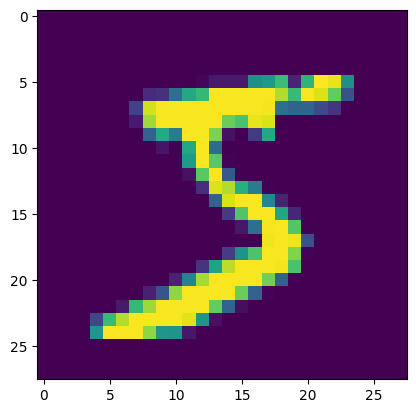

In [3]:
# Load the MNIST dataset
#train_dataset, validation_dataset, test_dataset = keras.datasets.celeba.load_data()

(x_train, _), (_, _) = keras.datasets.mnist.load_data()
plt.imshow(x_train[0])

In [4]:
x_train.shape

(60000, 28, 28)

## reshape&splitting

In [5]:

# (train_images,train_labels),(test_images,test_labels) = tf.keras.datasets.mnist.load_data()
# Normalize the pixel values to be between -1 and 1
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train.shape

(60000, 28, 28, 1)

## Normalize

In [6]:
x_train = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]


## slices and batch

In [7]:



# Create a tf.data.Dataset object for the MNIST dataset
dataset = tf.data.Dataset.from_tensor_slices(x_train)
#dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [8]:
dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# bulid the model

## discriminator_model

In [9]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

## generator_model

In [10]:
def make_generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [11]:
generator = make_generator_model()
discriminator = make_discriminator_model()

## discriminator_loss & generator_loss func

In [12]:
# Define the loss functions for the generator and discriminator
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


## set the optimizer

In [13]:
# Define the optimizers for the generator and discriminator
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

In [14]:
# noise_dim = 100
# num_examples_to_generate = 16

# # We'll re-use this random vector used to seed the generator so
# # it will be easier to see the improvement over time.
# random_vector_for_generation = tf.random.normal([num_examples_to_generate,
#                                                  noise_dim])

In [15]:
# random_vector_for_generation

# model training

In [16]:
# EPOCHS = 50


# Define the training loop
def train_step(images):
    # Generating noise from a normal distribution
    fake_img_noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(fake_img_noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        print("gen_loss" , np.mean(gen_loss))
        print("disc_loss" , np.mean(disc_loss))
        #print("gen_loss" , gen_loss)


# Train the GAN model
def train(dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            train_step(batch)



In [17]:
# Train the GAN model
train(dataset, EPOCHS)  

Streaming output truncated to the last 5000 lines.
gen_loss tf.Tensor(1.0450724, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2066262, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0877366, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1611848, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9733765, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1671478, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95082223, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1476316, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88340825, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2258832, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93468034, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2155395, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98296183, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2113199, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9418803, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1567674, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0274978, shape=(), dtype=float32)
di

# show generated image

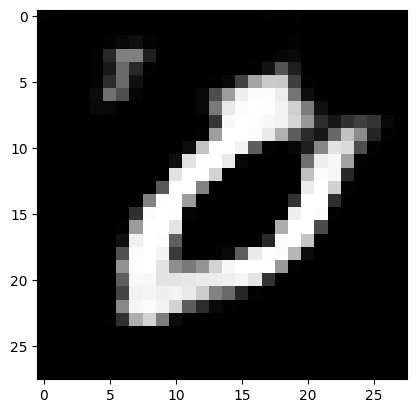

In [18]:
plt.imshow(generator(np.random.randn(1,100)).reshape(28,28),cmap='gray')


In [19]:
a = np.random.randn(2,100)
a.shape

(2, 100)

# save & load weights

In [20]:
# Save the generator weights to a file
generator.save_weights('generator_weights.h5')

# Load the generator weights from the file
generator.load_weights('generator_weights.h5')


# Generate new fake images

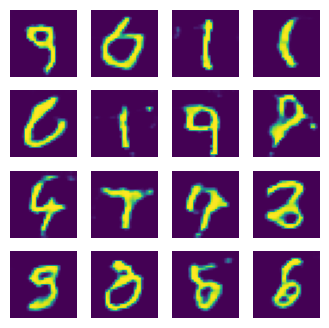

In [21]:

# Generate some fake images using the trained generator
noise = tf.random.normal([num_examples_to_generate, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4,4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((generated_images[i]*0.5 + 0.5).numpy())
    plt.axis('off')
plt.show()

# References

https://www.youtube.com/watch?v=56rCSTUaYsA